# 4. Building a deep neural network in Keras

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
TRAIN_DATA = "./data/train/train_data.csv"
VAL_DATA = "./data/val/val_data.csv"
TEST_DATA = "./data/test/test_data.csv"

In [4]:
def load_data():
    '''Load train, val and test datasets from disk.'''
    train = pd.read_csv(TRAIN_DATA)
    val = pd.read_csv(VAL_DATA)
    test = pd.read_csv(TEST_DATA)
    
    '''Using sklearn's StandardScaler to scale our data to 0 mean and unit variance.'''
    scaler = StandardScaler()
    train = scaler.fit_transform(train)
    val = scaler.transform(val)
    test = scaler.transform(test)
    
    '''We will use a dict to keep all this data.'''
    data = dict()
    data['train_y'] = train[:, 10]
    data['train_X'] = train[:, 0:9]
    data['val_y'] = val[:, 10]
    data['val_X'] = val[:, 0:9]
    data['test_y'] = test[:, 10]
    data['test_X'] = test[:, 0:9]
    
    '''Keep the `scaler` so we can unscale prediction in the future.'''
    data['scaler'] = scaler
    
    return data

* Bây giờ chúng ta sẽ thay đổi một chút hàm `build_network` mà ta đã làm trong file [01.alcohol_prediction.ipynb](./01.alcohol_prediction.ipynb).
* Chúng ta sẽ giữ nguyên input layer và output layer.
* Thay vì một hidden layer như trước, bây giờ ta có 5 hidden layer với 4 layer đầu 32 neutron và layer cuối có 16 neutron như hình dưới đây:<br>
  <center>

    ![](./images/02.02.png)
    _Hình 4.1_

  </center>

In [5]:
def build_network(input_features=None):
    # first we specify an input layer, with a shape == features
    inputs = Input(shape=(input_features,), name="input")
    x = Dense(32, activation='relu', name="hidden1")(inputs)
    x = Dense(32, activation='relu', name="hidden2")(x)
    x = Dense(32, activation='relu', name="hidden3")(x)
    x = Dense(32, activation='relu', name="hidden4")(x)
    x = Dense(16, activation='relu', name="hidden5")(x)
    # for regression we will use a single neuron with linear (no) activation
    prediction = Dense(1, activation='linear', name="final")(x)

    model = Model(inputs=inputs, outputs=prediction)
    model.compile(optimizer='adam', loss='mean_absolute_error')
    
    return model

* Bây giờ ta sẽ tiến hành build model

In [6]:
'''Load data'''
data = load_data()

'''Get dataset's number of features'''
input_features = data['train_X'].shape[1]

In [7]:
'''Define the Keras network'''
model = build_network(input_features=input_features)

'''Training'''
model.fit(x=data["train_X"], y=data["train_y"], 
          batch_size=32, epochs=500, verbose=1, 
          validation_data=(data["val_X"], data["val_y"]))

Epoch 1/500
123/123 [==============================] - 1s 3ms/step - loss: 0.5246 - val_loss: 0.3489
Epoch 2/500
123/123 [==============================] - 0s 2ms/step - loss: 0.3057 - val_loss: 0.2908
Epoch 3/500
123/123 [==============================] - 0s 2ms/step - loss: 0.2650 - val_loss: 0.2505
Epoch 4/500
123/123 [==============================] - 0s 2ms/step - loss: 0.2465 - val_loss: 0.2407
Epoch 5/500
123/123 [==============================] - 0s 2ms/step - loss: 0.2329 - val_loss: 0.2427
Epoch 6/500
123/123 [==============================] - 0s 2ms/step - loss: 0.2254 - val_loss: 0.2447
Epoch 7/500
123/123 [==============================] - 0s 2ms/step - loss: 0.2223 - val_loss: 0.2304
Epoch 8/500
123/123 [==============================] - 0s 2ms/step - loss: 0.2206 - val_loss: 0.2328
Epoch 9/500
123/123 [==============================] - 0s 3ms/step - loss: 0.2118 - val_loss: 0.2484
Epoch 10/500
123/123 [==============================] - 0s 2ms/step - loss: 0.2131 - val_lo

* Save lại model

In [8]:
model.save("./models/wine_quality_5hidden/regression_model")

INFO:tensorflow:Assets written to: ./models/wine_quality_5hidden/regression_model/assets


## 4.1. Measuring the deep neural network performance
* Bây giờ dùng lại MAE loss function để đánh giá model.

In [9]:
mae_train = mean_absolute_error(data["train_y"], model.predict(data["train_X"]))
mae_val = mean_absolute_error(data["val_y"], model.predict(data["val_X"]))
mae_test = mean_absolute_error(data["test_y"], model.predict(data["test_X"]))

print("Model Train MAE: {}".format(mae_train))
print("Model Val MAE: {}".format(mae_val))
print("Model Test MAE: {}".format(mae_test))

Model Train MAE: 0.0752571229374233
Model Val MAE: 0.19587000676920713
Model Test MAE: 0.19029535009273887


> **Nhận xét**:
> * Chúng ta có thể thấy rằng MAE trên train đã giảm từ 0.19 xuống 0.075. Vậy chúng ta đã thành công trong việc giảm bias error.
> * Tuy nhiên, lúc này variance error lại tăng. Khoảng cách giữa MAE trên training data và test data quá lớn.
> * Lỗi trên val data giảm nhẹ, điều này tốt tuy nhiên nhìn lại lỗi trên val data và test data cũng có khoảng cách quá lớn, vậy model của chúng ta đang quá khớp với training data $\Rightarrow$ model bị overfitting.
> * Cách đơn giản nhất để giảm variance error là thêm dữ liệu vào cho training data. Hoặc sư dụng các kĩ thuật regularization như **L2 regularization** hoặc **Dropout** _(đã giới thiệu ở Chapter 01)_, chúng ta sẽ tìm hiểu các kĩ thuật này vào chương sau.
> * Tuy nhiên, người ta cho rằng, khi overfitting xảy ra, cách tốt nhất vẫn là nên cố gắng đi bổ sung dữ liệu cho training dataset.

* Bây giờ chúng ta sẽ vẽ biểu đồ distplot để xem giữa true value và predicted value khác nhau bao nhiêu.

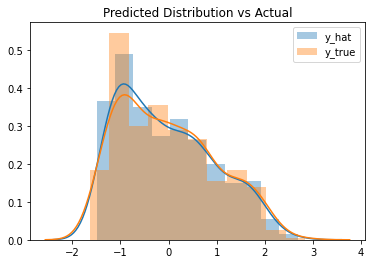

In [12]:
y_hat = model.predict(data["test_X"])

plt.title("Predicted Distribution vs Actual")
sns.distplot(y_hat.flatten(), label="y_hat")
sns.distplot(data["test_y"], label="y_true")
plt.legend()
plt.savefig("./data/pred_dist_deep.jpg")

> **Nhận xét**
> * Mặc dù MAE trên test data khác biệt nhiều so với training data, nhưng nhìn chung phân phối của các giá trị được model dự đoán bị lệch một chút về bên phải so với phân phối của các true value, đây có thể là một thông tin quan trọng. Nói cách khác, model của chúng ta đang dự đoán các loại rượu có độ cồn (alcohol) cao hơn so với thực tế.
> * Phân phối của predicted value cao hơn so với true value ở trái (khoảng giữa -2 và -1), model dự đoán sai ở đây khá nhiều mẫu.
> * Ta có thể kiểm tra lại val data từ đó có thể rút ra cách mà ta nên thu thập thêm data cho training data.

## 4.2. Tuning the model hyperparameters
* Bây giờ, chúng ta sẽ tìm hiểu cách điều chỉnh và tối ưu hóa các hyperparameter trong network.
* Chúng ta sẽ tìm hiểu sau hơn trong **Chapter 06. Hyperparameter Optimization**. Có nhiều chiến lược để chọn ra các hyperparameter tốt nhất cho model.
* Như các ví dụ từ trước cho đến nay, có rất nhiều parameter và hyperparameter mà ta cần phải tối ưu.
* Sau đây là các cách mà ta sẽ tối ưu hóa cho các parameter và hyperparameter của model:
  * Thử thay đổi số lượng hidden layer. Các ví dụ của chúng ta có vẻ 5 là quá nhiều nhưng 1 là chưa đủ.
  * Thử thay đổi số lượng neutron ở mỗi layer.
  * Thử nghiệm với các kĩ thuật như **dropout** và **regularization** _(tìm hiểu sau)_.
  * Sử dụng các optimizer khác như SGD, RMSProp thay vì Adam hoặc tăng learning rate cho Adam.

# 5. Saving and loading a trained Keras model
* Để lưu model:
  ```python
  model.save("/models/regression_model")
  ```

* Load model:
  ```python
  from keras.models import load_model

  model = load_model("/models/regression_model")
  ```

# 6. Summary
* Tóm lại, khi ta xây dựng một network cần tiến hành các bước:
  * Xác định vấn đề.
  * Xác định input và output.
  * Chọn loss function.
  * Xây dựng network architecture.
  * Đào tạo network.
  * Hiểu chỉnh network.
* Bias error và variance error có thể được điều khiển và giảm một cách độc lập trong neural network nếu các yếu tố sau được quan tâm:
  * Bias error: có thể giảm bằng tăng sự phức tạp của model bằng cách bổ sung thêm layer, neutron hoặc cả hai. Thêm dữ liệu ở lỗi này không thể giảm lỗi.
  * Variance error: có thể giảm bằng cách thêm dữ liệu hoặc dùng các kĩ thuật regularization _(tìm hiểu sau)_.